<a href="https://colab.research.google.com/github/DChulok/I-want-to-learn-NLP/blob/master/Overfit_it_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
       BatchNorm1d-7                   [-1, 64]             128
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                   [-1, 32]           2,080
      BatchNorm1d-11                   [-1, 32]              64
             ReLU-12                   [-1, 32]               0
          Dropout-13                   [-1, 32]               0
           Linear-14                   

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

n_epoch = 15
mean_train_losses = []

for e in range(n_epoch):
  epoch_train_losses = np.array([])
  for i, batch in enumerate(train_loader):
    imgs, labels = batch
    imgs_ = imgs.to(device)
    labels_ = labels.to(device)

    model.train(True)
    model.zero_grad()

    output = model.forward(imgs_)
    loss = loss_func(output, labels_)

    loss.backward()
    
    loss_ = loss.detach().cpu().numpy()
    epoch_train_losses = np.append(epoch_train_losses, loss_)

    opt.step()
    
  mean_train_losses.append(epoch_train_losses.mean())

  print(f"Epoch {e}")
  print(f"Mean epoch train loss: {mean_train_losses[-1]}")

# Your experiments, training and validation loops here

Epoch 0
Mean epoch train loss: 0.6993377474325297
Epoch 1
Mean epoch train loss: 0.4331253862330146
Epoch 2
Mean epoch train loss: 0.39500894685035576
Epoch 3
Mean epoch train loss: 0.3654751468823154
Epoch 4
Mean epoch train loss: 0.3499556719811995
Epoch 5
Mean epoch train loss: 0.3335766552417263
Epoch 6
Mean epoch train loss: 0.32422916057394513
Epoch 7
Mean epoch train loss: 0.3155867419580915
Epoch 8
Mean epoch train loss: 0.30397266816737045
Epoch 9
Mean epoch train loss: 0.2978011873929994
Epoch 10
Mean epoch train loss: 0.28700129370064115
Epoch 11
Mean epoch train loss: 0.28049285341300434
Epoch 12
Mean epoch train loss: 0.2776903808752357
Epoch 13
Mean epoch train loss: 0.27135008627544843
Epoch 14
Mean epoch train loss: 0.26259435119151053


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
model_predictions = []
test_labels = []
model.train(False)
for imgs, labels in test_loader:
  imgs_ = imgs.to(device)

  with torch.no_grad():
    output = model.forward(imgs_)
  preds = torch.argmax(output, dim=1)

  model_predictions += preds.detach().cpu().tolist()
  test_labels += labels.tolist()


In [ ]:
accuracy_score(test_labels, model_predictions)

0.8902

We've gotten it!

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
# let's create small train and validation datasets
small_train = []
small_valid = []
for i, b in enumerate(train_loader):
  if i < 79:
    small_train.append(b)
  elif i < 102:
    small_valid.append(b)
  else:
    break

Now, our small train dataset constist of 128*79=10112 samples

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 64]          16,448
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 16]             528
             ReLU-11                   [-1, 16]               0
           Linear-12                   [-1, 10]             170
Total params: 552,474
Trainable params: 552,474
Non-trainable params: 0
-------------------------------

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

mean_train_losses = []
mean_valid_losses = []
acc_train = []
acc_valid = []

n_epoch = 50

for e in range(n_epoch):
  epoch_train_losses = []
  epoch_valid_losses = []
  train_preds, valid_preds = [], []
  train_labels, valid_labels = [], []
  # train
  for i, batch in enumerate(small_train):
    imgs, labels = batch
    imgs_, labels_ = imgs.to(device), labels.to(device)

    model.train(True)
    model.zero_grad()

    output = model.forward(imgs_)
    loss = loss_func(output, labels_)

    loss.backward()
    opt.step()

    epoch_train_losses.append(loss.item())

    train_preds.extend(torch.argmax(output.detach().cpu(), dim=1).tolist())
    train_labels.extend(labels)

  # validation
  for i, batch in enumerate(small_valid):
    imgs, labels = batch
    imgs_, labels_ = imgs.to(device), labels.to(device)

    model.eval()
    with torch.no_grad():
      output = model.forward(imgs_)
    
    loss = loss_func(output, labels_)

    epoch_valid_losses.append(loss.item())

    valid_preds.extend(torch.argmax(output.detach().cpu(), dim=1).tolist())
    valid_labels.extend(labels)

  mean_train_losses.append(np.mean(np.asarray(epoch_train_losses)))
  mean_valid_losses.append(np.mean(np.asarray(epoch_valid_losses)))

  # accuracy after the current epoch
  acc_train.append(accuracy_score(train_labels, train_preds))
  acc_valid.append(accuracy_score(valid_labels, valid_preds))

  if e % 5 == 1:
    print(f"Epoch: {e}")
    print(f"Mean epoch train loss: {mean_train_losses[-1]}")
    print(f"Mean epoch valid loss: {mean_valid_losses[-1]}")
    

Epoch: 1
Mean epoch train loss: 1.0281344712535037
Mean epoch valid loss: 0.8357137234314628
Epoch: 6
Mean epoch train loss: 0.49983594877810417
Mean epoch valid loss: 0.5226782365985538
Epoch: 11
Mean epoch train loss: 0.40501238820673546
Mean epoch valid loss: 0.47316688299179077
Epoch: 16
Mean epoch train loss: 0.35473645223846917
Mean epoch valid loss: 0.4588443740554478
Epoch: 21
Mean epoch train loss: 0.32480972269667857
Mean epoch valid loss: 0.4435134504152381
Epoch: 26
Mean epoch train loss: 0.2933930811248248
Mean epoch valid loss: 0.44948298386905505
Epoch: 31
Mean epoch train loss: 0.2753169604494602
Mean epoch valid loss: 0.4686080230318982
Epoch: 36
Mean epoch train loss: 0.26113199942474125
Mean epoch valid loss: 0.503932799981988
Epoch: 41
Mean epoch train loss: 0.2362408294707914
Mean epoch valid loss: 0.520941295053648
Epoch: 46
Mean epoch train loss: 0.2248123078783856
Mean epoch valid loss: 0.5091734722904537


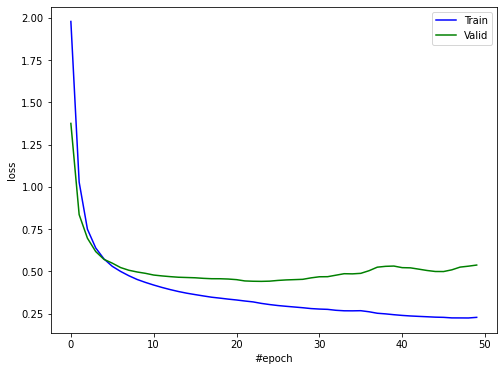

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(mean_train_losses, 'b', label='Train')
plt.plot(mean_valid_losses, 'g', label='Valid')
plt.legend()

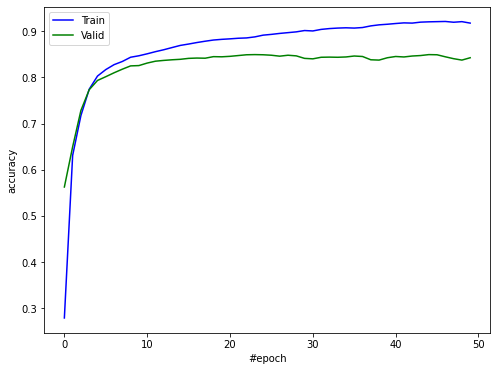

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(acc_train, 'b', label='Train')
plt.plot(acc_valid, 'g', label='Valid')
plt.legend()

We can see that after ~20th epoch model's loss on train is decreasing while loss on validation data is starting to grow. Almost the same we could see with accuraces. Such results are indicating that our model overfits the train set.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 64]          16,448
      BatchNorm1d-11                   [-1, 64]             128
             ReLU-12                   [-1, 64]               0
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

mean_train_losses = []
mean_valid_losses = []
acc_train = []
acc_valid = []

n_epoch = 50

for e in range(n_epoch):
  epoch_train_losses = []
  epoch_valid_losses = []
  train_preds, valid_preds = [], []
  train_labels, valid_labels = [], []

  # train
  for i, batch in enumerate(small_train):
    imgs, labels = batch
    imgs_, labels_ = imgs.to(device), labels.to(device)

    model.train(True)
    model.zero_grad()

    output = model.forward(imgs_)
    loss = loss_func(output, labels_)

    loss.backward()
    opt.step()

    epoch_train_losses.append(loss.item())

    train_preds.extend(torch.argmax(output.detach().cpu(), dim=1).tolist())
    train_labels.extend(labels)

  # validation
  for i, batch in enumerate(small_valid):
    imgs, labels = batch
    imgs_, labels_ = imgs.to(device), labels.to(device)

    model.eval()
    with torch.no_grad():
      output = model.forward(imgs_)
    
    loss = loss_func(output, labels_)

    epoch_valid_losses.append(loss.item())

    valid_preds.extend(torch.argmax(output.detach().cpu(), dim=1).tolist())
    valid_labels.extend(labels)

  mean_train_losses.append(np.mean(np.asarray(epoch_train_losses)))
  mean_valid_losses.append(np.mean(np.asarray(epoch_valid_losses)))

  # accuracy after the current epoch
  acc_train.append(accuracy_score(train_labels, train_preds))
  acc_valid.append(accuracy_score(valid_labels, valid_preds))

  if e % 5 == 1:
    print(f"Epoch: {e}")
    print(f"Mean epoch train loss: {mean_train_losses[-1]}")
    print(f"Mean epoch valid loss: {mean_valid_losses[-1]}")
    

Epoch: 1
Mean epoch train loss: 1.6563793375522275
Mean epoch valid loss: 1.4457886737325918
Epoch: 6
Mean epoch train loss: 0.9640743830535985
Mean epoch valid loss: 0.77286631387213
Epoch: 11
Mean epoch train loss: 0.6611962876742399
Mean epoch valid loss: 0.5362030410248301
Epoch: 16
Mean epoch train loss: 0.5294061925592302
Mean epoch valid loss: 0.4520737865696783
Epoch: 21
Mean epoch train loss: 0.45148412487174894
Mean epoch valid loss: 0.45049965640772943
Epoch: 26
Mean epoch train loss: 0.41282055630714076
Mean epoch valid loss: 0.4251604261605636
Epoch: 31
Mean epoch train loss: 0.37050915933862516
Mean epoch valid loss: 0.4267096804535907
Epoch: 36
Mean epoch train loss: 0.33237710538544235
Mean epoch valid loss: 0.44192752501238947
Epoch: 41
Mean epoch train loss: 0.2981205576960045
Mean epoch valid loss: 0.4465009583079297
Epoch: 46
Mean epoch train loss: 0.2807044984796379
Mean epoch valid loss: 0.45508711623108905


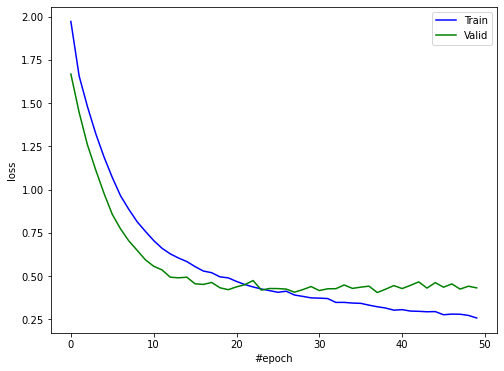

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(mean_train_losses, 'b', label='Train')
plt.plot(mean_valid_losses, 'g', label='Valid')
plt.legend()

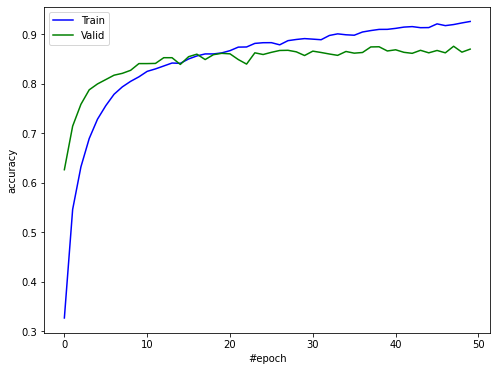

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(acc_train, 'b', label='Train')
plt.plot(acc_valid, 'g', label='Valid')
plt.legend()

### Conclusions:

We see that some regularization techniques like batch normalization and dropout could help us to prevent model from overfitting on train. Unlike the case when we didn't use them, while we continue to train model, validation loss is not increasing (accuracy is not decreasing), or at least it happens not so much.